In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, concatenate)
from keras.models import Model, Sequential
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [13]:
videos = [1,2,3,4,5,6]
scale_percent_original = 10
scale_percent_DT = 20
xsplit=45
ysplit=25

ERROR! Session/line number was not unique in database. History logging moved to new session 727


In [9]:
# Load resized original images of all six videos 

imagesAllVideos = np.zeros((18000,int(1088*scale_percent_original/100),int(1920*scale_percent_original/100),3), dtype=np.uint8)
shape=0
for i in videos:
    images = np.load('ImageFrames/Images_Video' + str(i) + '_' + str(scale_percent_original) + '.npy')
    imagesAllVideos[shape:shape+images.shape[0]] = images
    shape = shape + images.shape[0]
imagesAllVideos = imagesAllVideos[0:shape]
print('Original Images: ',imagesAllVideos.shape)

Original Images:  (17993, 108, 192, 3)


In [10]:
# Load resized dilated and thresholded images of all six videos 

imagesDilatedThresholdedAllVideos = np.zeros((18000,int(1088*scale_percent_DT/100),int(1920*scale_percent_DT/100)), dtype=np.uint8)
shape=0
for i in videos:
    images = np.load('ImageFrames/Images_DilatedThresholded_Video' + str(i) + '_' + str(scale_percent_DT) + '.npy')
    imagesDilatedThresholdedAllVideos[shape:shape+images.shape[0]] = images
    shape = shape + images.shape[0]
imagesDilatedThresholdedAllVideos = imagesDilatedThresholdedAllVideos[0:shape]
print('Dilated and thresholded images:', imagesDilatedThresholdedAllVideos.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 726
Dilated and thresholded images: (17993, 217, 384)


In [16]:
# Load annotations for the discrete grid number in which the ball is for all image frames

classifyLocationAnnotationsAllVideos = np.zeros((18000,1), dtype=np.uint32)
shape=0
for i in videos:
    annos = np.load('AnnotationFiles/Annotations_ClassifyLocations_Video' + str(i) + '_' + str(xsplit) + '_' + str(ysplit) + '_' + str(scale_percent_original) + '.npy')
    classifyLocationAnnotationsAllVideos[shape:shape+annos.shape[0]] = annos
    shape = shape + annos.shape[0]
classifyLocationAnnotationsAllVideos = classifyLocationAnnotationsAllVideos[0:shape]
print('Classify location annotations: ', classifyLocationAnnotationsAllVideos.shape)

Classify location annotations:  (17993, 1)


In [17]:
# Load annotations for the last ten discrete grid numbers in which the ball was for all image frames

lastTenLocationsAnnotations = np.zeros((18000,10), dtype=np.uint32)
shape=0
for i in [1,2,3,4,5,6]:
    annos = np.load('AnnotationFiles/AnnotationLastTenLocs_Video' + str(i) + '_' + str(xsplit) + '_' + str(ysplit) + '_' + str(scale_percent_original) + '.npy')
    lastTenLocationsAnnotations[shape:shape+annos.shape[0]] = annos
    shape = shape + annos.shape[0]
lastTenLocationsAnnotations = lastTenLocationsAnnotations[0:shape]
print('Last ten location annotations: ', lastTenLocationsAnnotations.shape)

Last ten location annotations:  (17993, 10)


In [24]:
# Split available dataset to training, validation and testing datasets 

# Split original image data
X_train_OI, X_test_OI, y_train, y_test = train_test_split(imagesAllVideos, classifyLocationAnnotationsAllVideos, test_size=0.1667, random_state=1)
X_train_OI, X_val_OI, y_train, y_val  = train_test_split(X_train_OI, y_train, test_size=0.20009, random_state=1)

# Split dilated and thresholded image data
X_train_DTI, X_test_DTI, y_train, y_test = train_test_split(imagesDilatedThresholdedAllVideos, classifyLocationAnnotationsAllVideos, test_size=0.1667, random_state=1)
X_train_DTI, X_val_DTI, y_train, y_val  = train_test_split(X_train_DTI, y_train, test_size=0.20009, random_state=1)
# Add fourth dimension for grayscale image data
X_train_DTI = X_train_DTI[..., np.newaxis]
X_val_DTI = X_val_DTI[..., np.newaxis]
X_test_DTI = X_test_DTI[..., np.newaxis]

# Split last ten location annotation data
X_train_LTL, X_test_LTL, y_train, y_test = train_test_split(lastTenLocationsAnnotations, classifyLocationAnnotationsAllVideos, test_size=0.1667, random_state=1)
X_train_LTL, X_val_LTL, y_train, y_val  = train_test_split(X_train_LTL, y_train, test_size=0.20009, random_state=1)
    
print('X_train_OI',X_train_OI.shape)
print('X_val_OI',X_val_OI.shape)
print('X_test_OI',X_test_OI.shape)
print('X_train_DTI',X_train_DTI.shape)
print('X_val_DTI',X_val_DTI.shape)
print('X_test_DTI',X_test_DTI.shape)
print('X_train_LTL',X_train_LTL.shape)
print('X_val_LTL',X_val_LTL.shape)
print('X_test_LTL',X_test_LTL.shape)
print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

X_train_OI (11993, 108, 192, 3)
X_val_OI (3000, 108, 192, 3)
X_test_OI (3000, 108, 192, 3)
X_train_DTI (11993, 217, 384, 1)
X_val_DTI (3000, 217, 384, 1)
X_test_DTI (3000, 217, 384, 1)
X_train_LTL (11993, 10)
X_val_LTL (3000, 10)
X_test_LTL (3000, 10)
y_train (11993, 1)
y_val (3000, 1)
y_test (3000, 1)


In [25]:
# Process outputs to one-hot encoded categorical outputs

y_train_cat = to_categorical(y_train, xsplit*ysplit+1)
y_val_cat = to_categorical(y_val, xsplit*ysplit+1)
y_test_cat = to_categorical(y_test, xsplit*ysplit+1)

In [26]:
# Normalized input data to the range of [0,1] and save as float32 arrays

X_train_OI_normalized = X_train_OI.astype(np.float32)/255
X_val_OI_normalized = X_val_OI.astype(np.float32)/255
X_test_OI_normalized = X_test_OI.astype(np.float32)/255

X_train_DTI_normalized = X_train_DTI.astype(np.float32)/255
X_val_DTI_normalized = X_val_DTI.astype(np.float32)/255
X_test_DTI_normalized = X_test_DTI.astype(np.float32)/255

X_train_LTL_normalized = X_train_LTL.astype(np.float32)/255
X_val_LTL_normalized = X_val_LTL.astype(np.float32)/255
X_test_LTL_normalized = X_test_LTL.astype(np.float32)/255

In [27]:
# Build CNN network architecture

def network():
    
    # Define inputs
    sequence_OI = Input(shape=(int(1088*scale_percent_original/100),int(1920*scale_percent_original/100),3), name='Orignal_Images')
    sequence_DTI = Input(shape=(int(1088*scale_percent_DT/100),int(1920*scale_percent_DT/100),1), name='Dilated_Thresholded_Images')
    features_LTL = Input(shape=(10,), name='Last_Ten_Locations')

    # Define sequential CNN for the orignal images
    conv1 = Sequential()
    conv1.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=(int(1088*scale_percent_original/100),int(1920*scale_percent_original/100),3), activation='relu',padding='valid'))
    conv1.add(MaxPooling2D(pool_size=(2,2)))
    conv1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='valid'))
    conv1.add(MaxPooling2D(pool_size=(2,2)))
    conv1.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='valid'))
    conv1.add(MaxPooling2D(pool_size=(2,2)))
    conv1.add(Dropout(0.25))
    conv1.add(Flatten())
    part1 = conv1(sequence_OI)
    
    # Define sequential CNN for the dilated and thresholded images
    conv2 = Sequential()
    conv2.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=(int(1088*scale_percent_DT/100),int(1920*scale_percent_DT/100),1), activation='relu',padding='valid'))
    conv2.add(MaxPooling2D(pool_size=(2,2)))
    conv2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='valid'))
    conv2.add(MaxPooling2D(pool_size=(2,2)))
    conv2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='valid'))
    conv2.add(MaxPooling2D(pool_size=(2,2)))
    conv2.add(Dropout(0.25))
    conv2.add(Flatten())
    part2 = conv2(sequence_DTI)

    # Merge the features of the two flattend sequential CNNs of the images and the last ten location annotations
    merged = concatenate([part1, part2, features_LTL])

    # Add fully connected dense layers
    final = Dense(3000, activation='relu')(merged)
    final = Dense(1126, activation='softmax')(final) #1126 outputs for xsplit*ysplit + 1 possible outputs

    # Combine inputs and outputs to a model
    model = Model(inputs=[sequence_OI, sequence_DTI, features_LTL], outputs=[final])

    # Compile model with categorical cross-entropy loss function and stochastic gradient descent optimizer
    model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

    return model

model = network()
model.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 731
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Orignal_Images (InputLayer)     (None, 108, 192, 3)  0                                            
__________________________________________________________________________________________________
Dilated_Thresholded_Images (Inp (None, 217, 384, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1936)         9512        Orignal_Images[0][0]             
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 9200)         9368        Dilated_Thresholded_Images[0][

In [28]:
# Train model for 20 epochs with the provided training data with a batch size of 32 and validate with the validation data 

history = model.fit([X_train_OI_normalized, X_train_DTI_normalized, X_train_LTL_normalized], y_train_cat, epochs=20, batch_size=32, validation_data=([X_val_OI_normalized, X_val_DTI_normalized, X_val_LTL_normalized], y_val_cat))

Train on 11993 samples, validate on 3000 samples
Epoch 1/20
11993/11993 [==============================] - 1422s 119ms/step - loss: 2.3238 - accuracy: 0.7097 - val_loss: 1.8267 - val_accuracy: 0.7277
Epoch 2/20
11993/11993 [==============================] - 1350s 113ms/step - loss: 1.7053 - accuracy: 0.7415 - val_loss: 1.3270 - val_accuracy: 0.7790
Epoch 3/20
11993/11993 [==============================] - 1222s 102ms/step - loss: 1.1236 - accuracy: 0.7977 - val_loss: 1.0056 - val_accuracy: 0.8147
Epoch 4/20
11993/11993 [==============================] - 1226s 102ms/step - loss: 0.7345 - accuracy: 0.8385 - val_loss: 0.8431 - val_accuracy: 0.8313
Epoch 5/20
11993/11993 [==============================] - 1248s 104ms/step - loss: 0.5272 - accuracy: 0.8660 - val_loss: 0.7816 - val_accuracy: 0.8477
Epoch 6/20
11993/11993 [==============================] - 1215s 101ms/step - loss: 0.4184 - accuracy: 0.8797 - val_loss: 0.7453 - val_accuracy: 0.8530
Epoch 7/20
11993/11993 [=====================

In [30]:
# Evaluate model with the testing data that was not used for the training

model.evaluate([X_test_OI_normalized,  X_test_DTI_normalized, X_test_LTL_normalized], y_test_cat)

3000/3000 [==============================] - 84s 28ms/step


[0.704645654330651, 0.8989999890327454]

In [31]:
# Get predictions from the trained model

predictions = model.predict([X_test_OI_normalized,  X_test_DTI_normalized, X_test_LTL_normalized])
predictedLocations = np.argmax(predictions, axis=-1)

In [32]:
# Print classification report for the predicted locations

print(classification_report(y_test, predictedLocations))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2210
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.50      0.33      0.40         3
          13       0.00      0.00      0.00         3
          14       0.87      1.00      0.93        13
          15       0.90      0.82      0.86        11
          16       0.67      0.67      0.67         3
          17       0.60      1.00      0.75         3
          18       0.00      0.00      0.00         2
          19       1.00      0.50      0.67         2
          20       0.00    

C:\Users\klaus\anaconda3\envs\SCE4104\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\klaus\anaconda3\envs\SCE4104\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\klaus\anaconda3\envs\SCE4104\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\klaus\anaconda3

In [33]:
# Save model

model.save('Models/ClassificationLocations', )

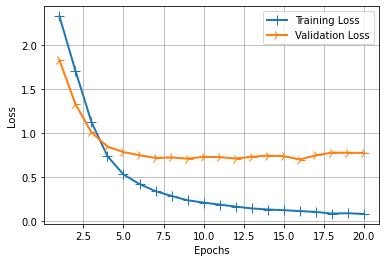

In [34]:
# Plot training and validation loss

history_dict = history.history

train_loss = history_dict['loss'][0:20] # Training loss
val_loss = history_dict['val_loss'][0:20] # Validation loss
epochs = range(1, len(train_loss) + 1) # Number of epochs

# Plot line charts
line1 = plt.plot(epochs, train_loss, label='Training Loss')
line2 = plt.plot(epochs, val_loss, label='Validation Loss')

# Plot markers
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# Label axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Include grid and legend
plt.grid(True)
plt.legend()

plt.show()

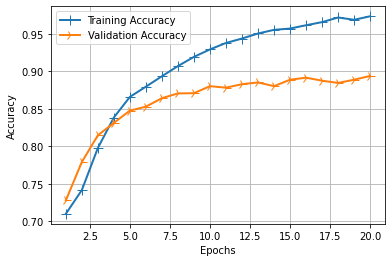

In [35]:
# Plot training and validation accuracy

history_dict = history.history

train_acc = history_dict['accuracy'][0:20] # Training accuracy
val_acc = history_dict['val_accuracy'][0:20] # Validation accuracy
epochs = range(1, len(train_loss) + 1) # Number of epochs

# Plot line charts
line1 = plt.plot(epochs, train_acc, label='Training Accuracy')
line2 = plt.plot(epochs, val_acc, label='Validation Accuracy')

# Plot markers
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# Label axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Include grid and legend
plt.grid(True)
plt.legend()

plt.show()